In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/PCD/Praktikum Morfologi dan CNN/LATIHAN CNN/flowers'

if os.path.exists(base_dir):
    print("Directory exists")
else:
    print("Directory does not exist")

Mounted at /content/drive
Directory exists


In [4]:
print(os.listdir(base_dir))

['dandelion', 'tulip', 'daisy', 'rose', 'sunflower']


In [5]:
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


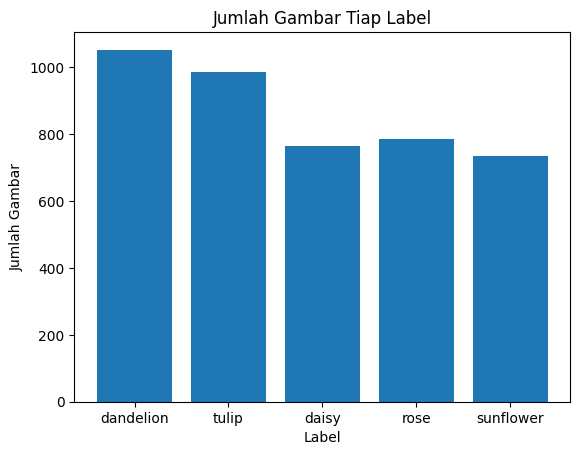

In [6]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

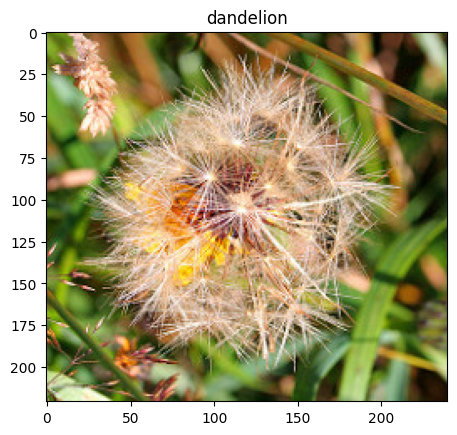

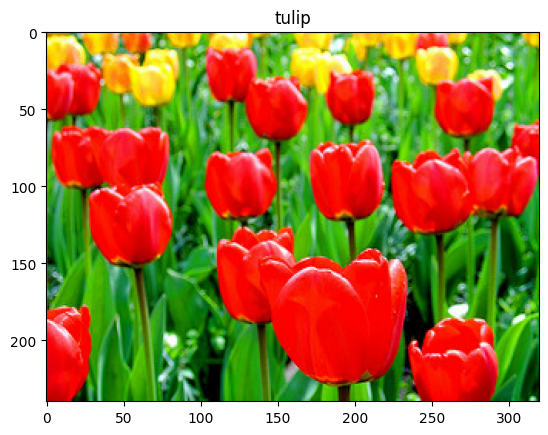

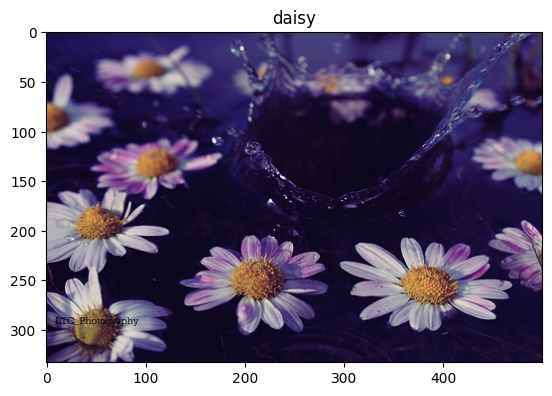

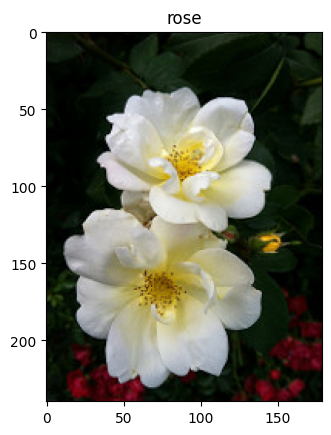

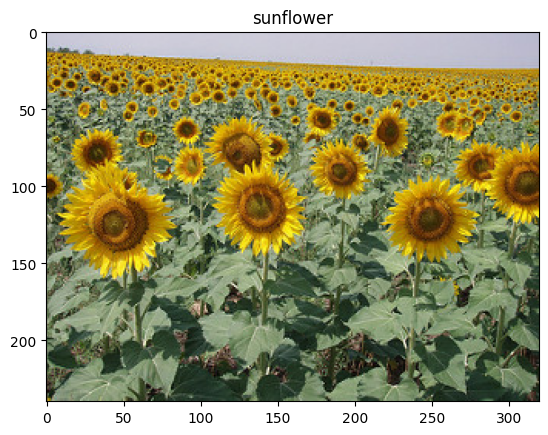

In [7]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

Data Preparation

In [8]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [9]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [10]:
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [11]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

# Modelling

**Membuat Arsitektur CNN**


Penyusunan Layer

In [12]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [13]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 750s 7s/step - loss: 1.3182 - accuracy: 0.4197 - val_loss: 1.1067 - val_accuracy: 0.5419
Epoch 2/20
109/109 [==============================] - 23s 212ms/step - loss: 1.0800 - accuracy: 0.5557 - val_loss: 1.0239 - val_accuracy: 0.5802
Epoch 3/20
109/109 [==============================] - 23s 207ms/step - loss: 0.9863 - accuracy: 0.6040 - val_loss: 0.9769 - val_accuracy: 0.6140
Epoch 4/20
109/109 [==============================] - 23s 209ms/step - loss: 0.9102 - accuracy: 0.6477 - val_loss: 0.8895 - val_accuracy: 0.6547
Epoch 5/20
109/109 [==============================] - 23s 214ms/step - loss: 0.8513 - accuracy: 0.6720 - val_loss: 1.0635 - val_accuracy: 0.6116
Epoch 6/20
109/109 [==============================] - 23s 210ms/step - loss: 0.8227 - accuracy: 0.6783 - val_loss: 0.8391 - val_accuracy: 0.7012
Epoch 7/20
109/109 [==============================] - 23s 214ms/step - loss: 0.7972 - accuracy: 0.6835 - val_loss: 0.8563 - val_accu

Evaluasi Model CNN

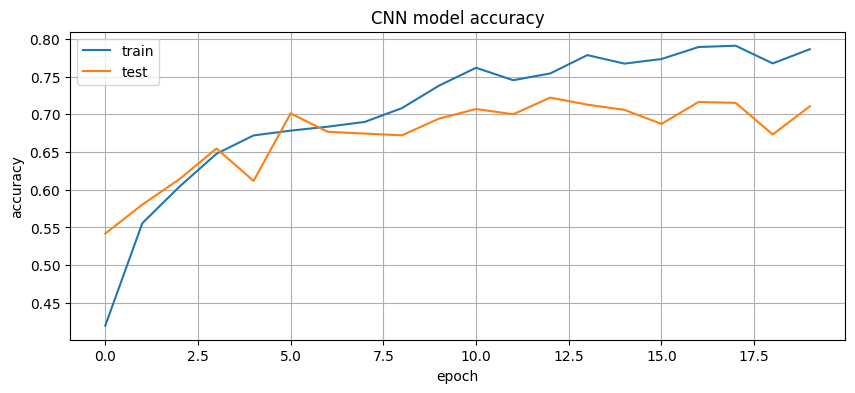

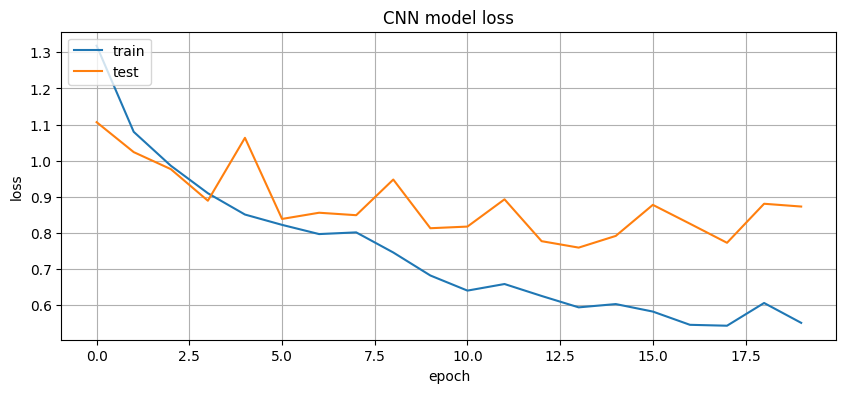

In [14]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning Menggunakan VGG16**

Memuat Model VGG16

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [17]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 36s 265ms/step - loss: 1.0938 - accuracy: 0.5670 - val_loss: 0.7288 - val_accuracy: 0.7349
Epoch 2/20
109/109 [==============================] - 26s 237ms/step - loss: 0.7664 - accuracy: 0.7145 - val_loss: 0.6472 - val_accuracy: 0.7535
Epoch 3/20
109/109 [==============================] - 24s 224ms/step - loss: 0.7338 - accuracy: 0.7295 - val_loss: 0.6298 - val_accuracy: 0.7767
Epoch 4/20
109/109 [==============================] - 24s 222ms/step - loss: 0.6528 - accuracy: 0.7585 - val_loss: 0.6369 - val_accuracy: 0.7872
Epoch 5/20
109/109 [==============================] - 24s 222ms/step - loss: 0.6422 - accuracy: 0.7614 - val_loss: 0.6248 - val_accuracy: 0.7802
Epoch 6/20
109/109 [==============================] - 24s 222ms/step - loss: 0.6291 - accuracy: 0.7706 - val_loss: 0.6114 - val_accuracy: 0.7919
Epoch 7/20
109/109 [==============================] - 25s 225ms/step - loss: 0.6364 - accuracy: 0.7593 - val_loss: 0.5349 - val_ac

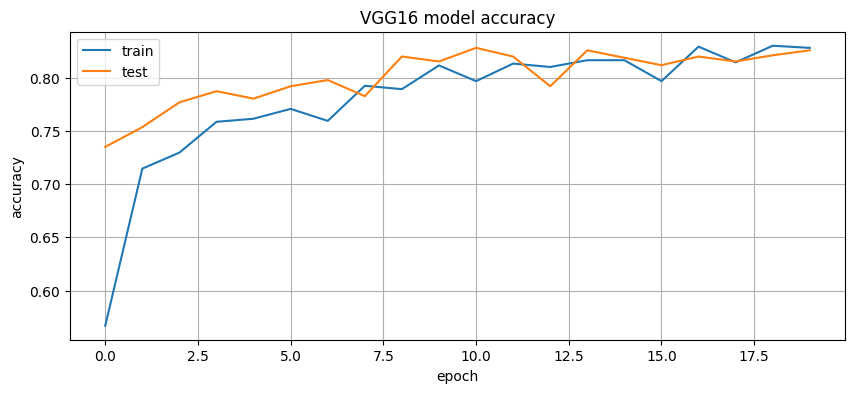

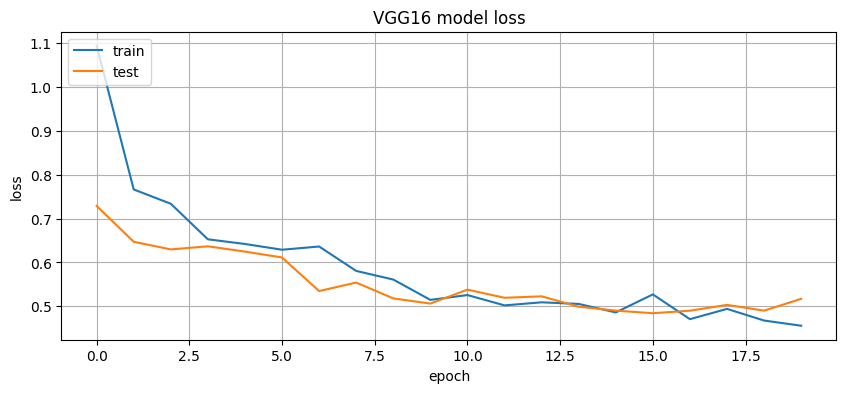

In [18]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning Menggunakan ResNet50**

Memuat Model ResNet50

In [19]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [21]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 32s 237ms/step - loss: 1.6635 - accuracy: 0.2661 - val_loss: 1.5146 - val_accuracy: 0.3826
Epoch 2/20
109/109 [==============================] - 29s 270ms/step - loss: 1.5495 - accuracy: 0.3341 - val_loss: 1.4559 - val_accuracy: 0.3756
Epoch 3/20
109/109 [==============================] - 23s 214ms/step - loss: 1.5461 - accuracy: 0.3237 - val_loss: 1.4641 - val_accuracy: 0.3500
Epoch 4/20
109/109 [==============================] - 24s 217ms/step - loss: 1.5294 - accuracy: 0.3246 - val_loss: 1.4344 - val_accuracy: 0.4047
Epoch 5/20
109/109 [==============================] - 23s 209ms/step - loss: 1.5222 - accuracy: 0.3350 - val_loss: 1.4445 - val_accuracy: 0.3826
Epoch 6/20
109/109 [==============================] - 23s 215ms/step - loss: 1.4661 - accuracy: 0.3639 - val_loss: 1.4646 - val_accuracy: 0.3419
Epoch 7/20
109/109 [==============================] - 23s 215ms/step - loss: 1.4720 - accuracy: 0.3769 - val_loss: 1.4217 - val_ac

Evaluasi Model

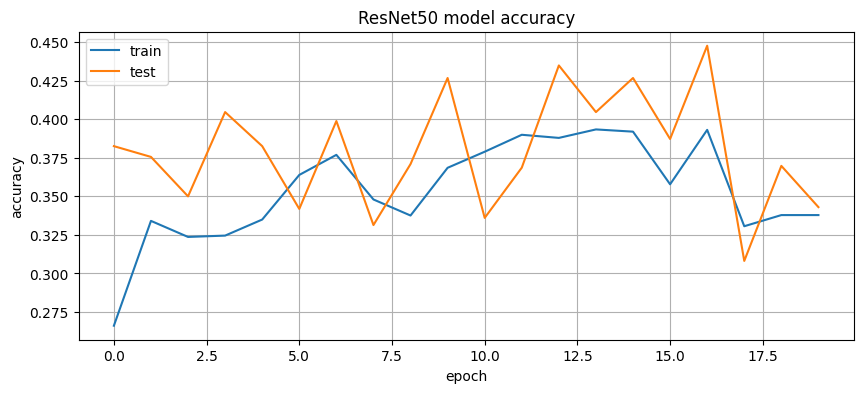

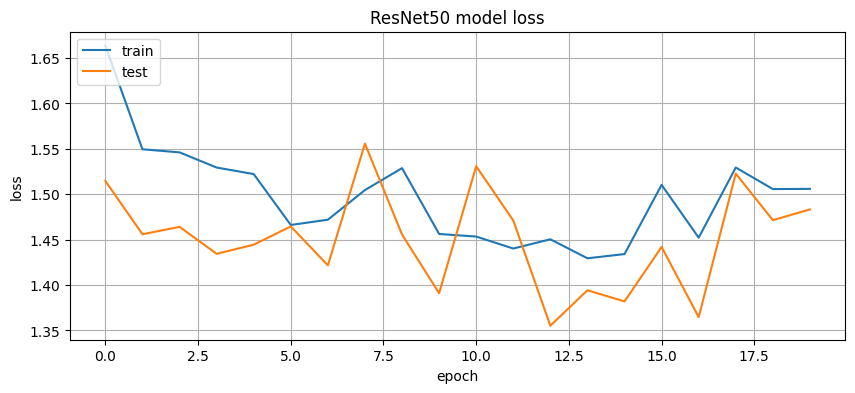

In [22]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning Menggunakan DenseNet201**

Memuat Model DenseNet201

In [23]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 0s 0us/step


In [24]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [25]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 47s 295ms/step - loss: 0.8629 - accuracy: 0.6656 - val_loss: 0.5083 - val_accuracy: 0.8116
Epoch 2/20
109/109 [==============================] - 28s 256ms/step - loss: 0.5198 - accuracy: 0.8050 - val_loss: 0.3980 - val_accuracy: 0.8523
Epoch 3/20
109/109 [==============================] - 25s 226ms/step - loss: 0.4342 - accuracy: 0.8403 - val_loss: 0.4127 - val_accuracy: 0.8500
Epoch 4/20
109/109 [==============================] - 25s 226ms/step - loss: 0.3935 - accuracy: 0.8577 - val_loss: 0.4038 - val_accuracy: 0.8593
Epoch 5/20
109/109 [==============================] - 29s 269ms/step - loss: 0.4533 - accuracy: 0.8392 - val_loss: 0.3783 - val_accuracy: 0.8698
Epoch 6/20
109/109 [==============================] - 25s 225ms/step - loss: 0.3833 - accuracy: 0.8701 - val_loss: 0.3484 - val_accuracy: 0.8744
Epoch 7/20
109/109 [==============================] - 24s 218ms/step - loss: 0.3732 - accuracy: 0.8681 - val_loss: 0.3844 - val_ac

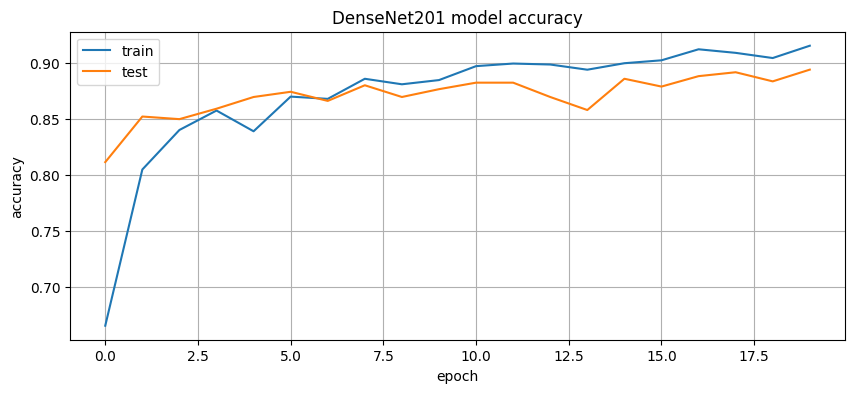

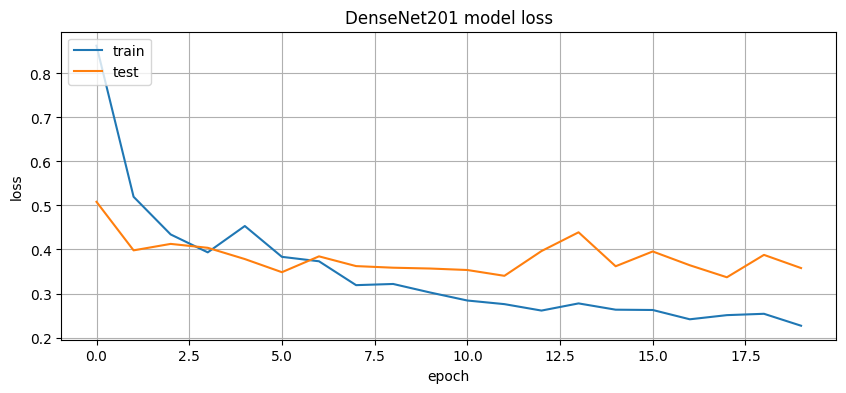

In [26]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Evaluasi**

pembandingan akurasi dari model model sebelumnya

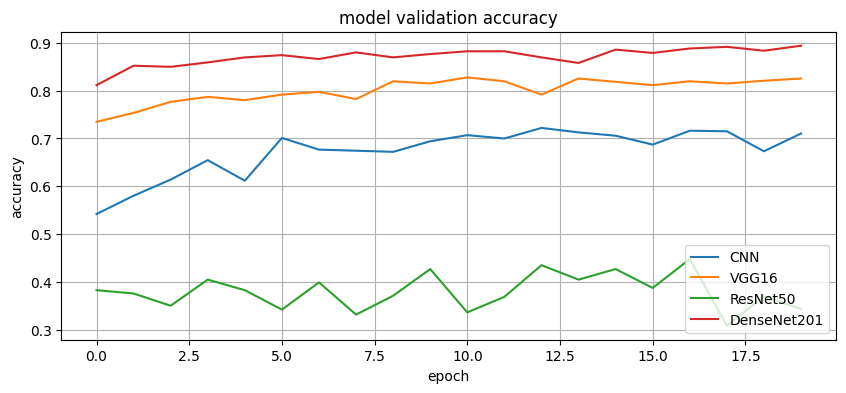

In [27]:
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

# **Uji Coba Model**

In [28]:
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Saving dandel.jpg to dandel (1).jpg
1/1 [==============================] - 3s 3s/step
dandel.jpg
dandelion


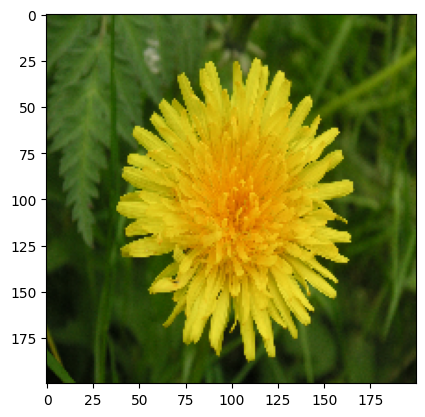

In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes == 0:
    print('daisy')
  elif classes == 1:
    print('dandelion')
  elif classes == 2:
    print('rose')
  elif classes == 3:
    print('sunflower')
  else:
    print('tulip')

# **Deployment**

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

In [32]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs

2023-07-03 15:36:02.346871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 817, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 500, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 76, in di